In [2]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum

# Set Spark version and Java environment variables
spark_version = 'spark-3.5.5'
os.environ['SPARK_VERSION']=spark_version
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
# prompt: start spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Mental Health Dataset").getOrCreate()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load dataset into a Spark DataFrame
df = spark.read.csv("/content/drive/My Drive/Colab Notebooks/Mental Health Dataset.csv", header=True, inferSchema=True)

# Display the schema and first few rows of the DataFrame
print("DataFrame Schema:")
df.printSchema()
df.show()

# Count total and distinct rows to identify duplicates
total_rows = df.count()
distinct_rows = df.distinct().count()
duplicate_count = total_rows - distinct_rows
print(f"\nTotal rows before removing duplicates: {total_rows}")
print(f"\nNumber of distinct rows: {distinct_rows}")
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Drop duplicate rows
df = df.dropDuplicates()
print(f"\nTotal rows after removing duplicates: {df.count()}")

# Count and display the number of null values in each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
print("\nNumber of missing values per column:")
null_counts.show()

# Drop rows with any null values
df = df.na.drop()
print(f"Total rows after removing rows with null values: {df.count()}")

# Optionally, show the cleaned DataFrame
df.show()

DataFrame Schema:
root
 |-- Timestamp: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- self_employed: string (nullable = true)
 |-- family_history: string (nullable = true)
 |-- treatment: string (nullable = true)
 |-- Days_Indoors: string (nullable = true)
 |-- Growing_Stress: string (nullable = true)
 |-- Changes_Habits: string (nullable = true)
 |-- Mental_Health_History: string (nullable = true)
 |-- Mood_Swings: string (nullable = true)
 |-- Coping_Struggles: string (nullable = true)
 |-- Work_Interest: string (nullable = true)
 |-- Social_Weakness: string (nullable = true)
 |-- mental_health_interview: string (nullable = true)
 |-- care_options: string (nullable = true)

+---------------+------+--------------+----------+-------------+--------------+---------+------------+--------------+--------------+---------------------+-----------+----------------+-------------+---------------+

In [5]:
# Save the cleaned DataFrame to a CSV file
output_path = "/mentalhealth_data.csv"
df.write.option("header", "true").csv(output_path)
print(f"\nCleaned data has been saved to: {output_path}")



Cleaned data has been saved to: /mentalhealth_data.csv


In [25]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Convert Spark DataFrame to Pandas
pandas_df = df.toPandas()

# Step 2: Process Timestamp
pandas_df['Timestamp'] = pd.to_datetime(pandas_df['Timestamp'], errors='coerce')
pandas_df['Year'] = pandas_df['Timestamp'].dt.year
pandas_df['Month'] = pandas_df['Timestamp'].dt.month
pandas_df['Day'] = pandas_df['Timestamp'].dt.day
pandas_df['Hour'] = pandas_df['Timestamp'].dt.hour
pandas_df = pandas_df.drop('Timestamp', axis=1)

# Step 3: Encode all object-type columns using LabelEncoder
label_encoders = {}
for col in pandas_df.columns:
    if pandas_df[col].dtype == 'object':
        pandas_df[col] = pandas_df[col].astype(str).fillna("NaN")
        le = LabelEncoder()
        pandas_df[col] = le.fit_transform(pandas_df[col])
        label_encoders[col] = le

# Step 4: Drop any rows with remaining NaNs
pandas_df = pandas_df.dropna()



In [26]:
# Step 5: Split features and target
X = pandas_df.drop('Mood_Swings', axis=1)
y = pandas_df['Mood_Swings']

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 7: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 8: Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Step 9: Predict and evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



✅ Accuracy: 0.4097

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.36      0.40     17739
           1       0.39      0.38      0.39     19588
           2       0.40      0.48      0.44     19645

    accuracy                           0.41     56972
   macro avg       0.42      0.41      0.41     56972
weighted avg       0.41      0.41      0.41     56972

🔍 Confusion Matrix:
[[6374 4676 6689]
 [4464 7517 7607]
 [3066 7131 9448]]


In [27]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Convert Spark DataFrame to Pandas
pandas_df = df.toPandas()

# Step 2: Process Timestamp
pandas_df['Timestamp'] = pd.to_datetime(pandas_df['Timestamp'], errors='coerce')
pandas_df['Year'] = pandas_df['Timestamp'].dt.year
pandas_df['Month'] = pandas_df['Timestamp'].dt.month
pandas_df['Day'] = pandas_df['Timestamp'].dt.day
pandas_df['Hour'] = pandas_df['Timestamp'].dt.hour
pandas_df = pandas_df.drop('Timestamp', axis=1)

# Step 3: Encode all object-type columns using LabelEncoder
label_encoders = {}
for col in pandas_df.columns:
    if pandas_df[col].dtype == 'object':
        pandas_df[col] = pandas_df[col].astype(str).fillna("NaN")
        le = LabelEncoder()
        pandas_df[col] = le.fit_transform(pandas_df[col])
        label_encoders[col] = le

# Step 4: Drop any remaining NaNs
pandas_df = pandas_df.dropna()

# Step 5: Split features and target
X = pandas_df.drop('Mood_Swings', axis=1)
y = pandas_df['Mood_Swings']

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ Note: RandomForest doesn't need feature scaling!
# Step 7: Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 8: Predict and evaluate
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Accuracy (Random Forest): {accuracy:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



✅ Accuracy (Random Forest): 0.9652

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     17739
           1       0.98      0.98      0.98     19588
           2       0.96      0.96      0.96     19645

    accuracy                           0.97     56972
   macro avg       0.97      0.96      0.97     56972
weighted avg       0.97      0.97      0.97     56972

🔍 Confusion Matrix:
[[17000   132   607]
 [   98 19226   264]
 [  617   265 18763]]


In [28]:
pip install xgboost

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Step 5: Split features and target
X = pandas_df.drop('Mood_Swings', axis=1)
y = pandas_df['Mood_Swings']

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 7: Train XGBoost model (multi-class softmax objective)
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Step 8: Predict and evaluate
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Accuracy (XGBoost): {accuracy:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:35:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ Accuracy (XGBoost): 0.9754

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17739
           1       0.98      0.99      0.99     19588
           2       0.97      0.96      0.97     19645

    accuracy                           0.98     56972
   macro avg       0.98      0.98      0.98     56972
weighted avg       0.98      0.98      0.98     56972

🔍 Confusion Matrix:
[[17246   144   349]
 [   16 19384   188]
 [  541   161 18943]]


<Figure size 1200x800 with 0 Axes>

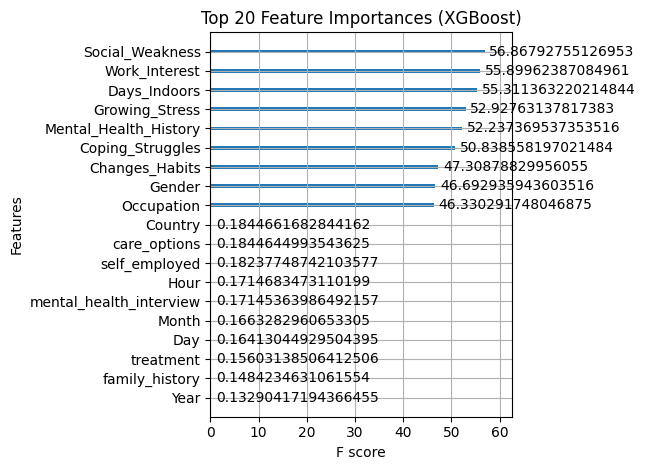

In [31]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(12, 8))
plot_importance(xgb_model, max_num_features=20, importance_type='gain')  # 'gain' shows how much each feature contributes
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [32]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# Wrap model
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best params and accuracy
print("🔍 Best Parameters:", grid_search.best_params_)
print("✅ Best Accuracy:", grid_search.best_score_)

# Re-train on full training set with best params
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
print("\n📈 Final Accuracy (Tuned XGBoost):", accuracy_score(y_test, y_pred_best))


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:00:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
✅ Best Accuracy: 0.979810080478836


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:00:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📈 Final Accuracy (Tuned XGBoost): 0.9788843642491049


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
✅ Best Accuracy: 0.9798320212737948


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:51:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📈 Final Accuracy (Tuned XGBoost): 0.9792880713332865


<Figure size 1200x800 with 0 Axes>

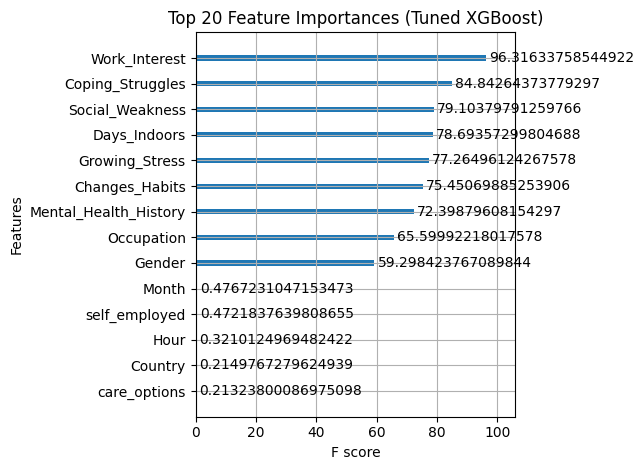

In [33]:
from sklearn.model_selection import GridSearchCV

# Step 1: Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],              # Maximum depth of trees (affects complexity)
    'learning_rate': [0.05, 0.1, 0.2],   # Learning rate (affects speed of convergence)
    'n_estimators': [100, 200],          # Number of trees (models in ensemble)
    'subsample': [0.8, 1.0],             # Fraction of samples used for each tree
    'colsample_bytree': [0.8, 1.0],      # Fraction of features used for each tree
    'gamma': [0, 0.1, 0.2],              # Regularization parameter (affects overfitting)
}

# Step 2: Set up the XGBoost classifier
xgb = XGBClassifier(
    objective='multi:softmax',           # Multi-class classification
    num_class=len(y.unique()),          # Number of classes
    eval_metric='mlogloss',              # Log loss (error metric for classification)
    use_label_encoder=False,
    random_state=42
)

# Step 3: Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,                        # The XGBoost model
    param_grid=param_grid,                # The parameter grid to search through
    scoring='accuracy',                   # Use accuracy to evaluate the models
    cv=3,                                 # 3-fold cross-validation
    verbose=1,                             # Print progress
    n_jobs=-1                              # Use all CPU cores for parallel processing
)

# Step 4: Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Step 5: Display the best parameters and best score
print("🔍 Best Parameters:", grid_search.best_params_)
print("✅ Best Accuracy:", grid_search.best_score_)

# Step 6: Re-train the best model on the full training data
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Step 7: Predict and evaluate the tuned model
y_pred_best = best_model.predict(X_test)
print("\n📈 Final Accuracy (Tuned XGBoost):", accuracy_score(y_test, y_pred_best))

# Optionally, visualize feature importances for the tuned model
plt.figure(figsize=(12, 8))
plot_importance(best_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (Tuned XGBoost)")
plt.tight_layout()
plt.show()


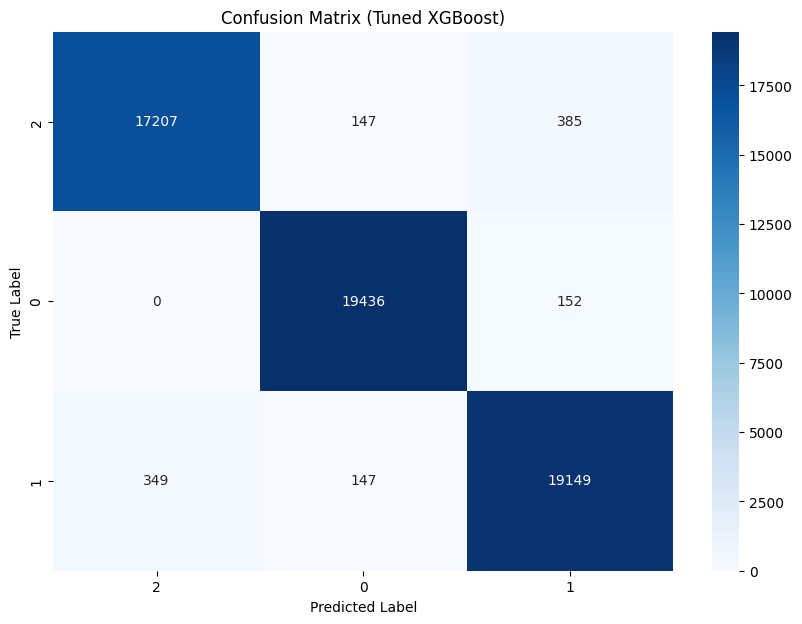


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     17739
           1       0.99      0.99      0.99     19588
           2       0.97      0.97      0.97     19645

    accuracy                           0.98     56972
   macro avg       0.98      0.98      0.98     56972
weighted avg       0.98      0.98      0.98     56972



In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Step 1: Predict with the best model
y_pred_best = best_model.predict(X_test)

# Step 2: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.title("Confusion Matrix (Tuned XGBoost)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 3: Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_best))


<Figure size 1200x800 with 0 Axes>

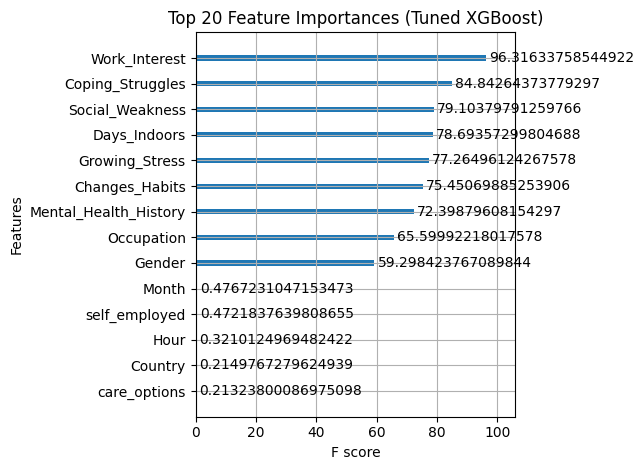

In [35]:
# Plot feature importance for the tuned model
plt.figure(figsize=(12, 8))
plot_importance(best_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances (Tuned XGBoost)")
plt.tight_layout()
plt.show()

